<a href="https://colab.research.google.com/github/lialic/vision_transformer/blob/main/Vision_Intel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer on Intel Image Classification Dataset

## Intel Classification Dataset
Dataset: https://www.kaggle.com/puneet6060/intel-image-classification/version/2 \
Number of classes: 6 categories\
Images data: 14k 150x150 train, 3k 150x150 test, 7k 150x150 validation
Information: Total of around 25k images of size 150x150 under 6 categories, it is about the scenary and publish by Intel as a Image Classification challenge. Each of the train, test and validation is stored in a zip file which I have downloaded from the link above and stored in my Google Drive account.\
For this project, I will get these zip file from Drive and unzip it in the env each and every time we connect this to the env.

## Vision Transformer
About the ViT used in this project, it is has been pretrained by Google on the JFT-300M dataset and only work pretty well on larger dataset, so as a medium dataset, let find out how it gonna come through.\
A bit of the introduction on Vision Transformer, there are 3 main parts of it: Linear Projection, Encoder and Classification head. The first and last one are all Dense layer but has different kind of operation on it while the Encoder may included several building block which contains Norm Layer, Multi-head Self-attention Layer and Residual skip connection, and these block has vertically stack together.


### Notice:
Pls change your runtime to GPU before run this notebook if this is not your default setting

## Install requirements and import libs

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 6.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Load from vision transformer folder model and dataset config

In [ ]:
# Clone repository and pull latest changes.
![ -d ./vision_transformer ] || git clone --depth=1 https://github.com/lialic/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 4), reused 21 (delta 1), pack-reused 0
Unpacking objects: 100% (37/37), done.
Already up to date.


In [ ]:
# Install requirements of model
!pip install -qr ./vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 77 kB 8.5 MB/s 
     |████████████████████████████████| 207 kB 29.5 MB/s 
     |████████████████████████████████| 88 kB 11.1 MB/s 
     |████████████████████████████████| 179.8 MB 49 kB/s 
     |████████████████████████████████| 126 kB 67.4 MB/s 


In [ ]:
from absl import logging
import flax
import jax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


[GpuDevice(id=0, process_index=0)]

In [ ]:
vit_path = './vision_transformer/vit_jax/'
from google.colab import files

# Open all files in vision_transformer configutarion to the side 
files.view(vit_path + 'configs/common.py')
files.view(vit_path + 'configs/models.py')
files.view(vit_path + 'checkpoint.py')
files.view(vit_path + 'input_pipeline.py')
files.view(vit_path + 'models.py')
files.view(vit_path + 'momentum_clip.py')
files.view(vit_path + 'train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Define basic params

Side Note: As the ViT does not work pretty well training from sratch, that's why they are prefer to load params from pre-train model and then make the last layer your own fit for the model.

In [ ]:
# Show all the available pre-trained models
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [ ]:
# Download the latest model into drive
import os
model_name = 'ViT-B_32'
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .

# # If the file does not exist in the path then tell
assert os.path.exists(f'{model_name}.npz')

In [ ]:
# Testing another model with less head
import os
model_name = 'ViT-B_16'
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .

# # If the file does not exist in the path then tell
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_16.npz...
/ [1 files][393.7 MiB/393.7 MiB]                                                
Operation completed over 1 objects/393.7 MiB.                                    


In [ ]:
import os
model_name = 'ViT-L_16'
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .

# # If the file does not exist in the path then tell
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-L_16.npz...
| [1 files][  1.2 GiB/  1.2 GiB]   54.0 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [ ]:
# Import some of the configs of Google from the opened files
import sys
import os 

if './vision_transformer' not in sys.path: # Move to the vision transformer folder
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

import jax
from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [ ]:
import shutil
path = '/content/drive/MyDrive/Data/Intel/' # path to all the zip files

data_path = '/content/intel'
os.mkdir(data_path)


shutil.unpack_archive(path+'train.zip', data_path, format='zip')
shutil.unpack_archive(path+'test.zip', data_path, format='zip')

In [ ]:
intel = 'intel' # Setting in common.py

config = common_config.with_dataset(common_config.get_config(), intel)
num_classes = input_pipeline.get_dataset_info(intel, 'train')['num_classes']
num_classes

6

In [ ]:
input_pipeline.get_dataset_info(intel, 'train')

{'examples_glob': '/content/intel/train/*/*.jpg',
 'int2str': <function vit_jax.input_pipeline.get_directory_info.<locals>.<lambda>>,
 'num_classes': 6,
 'num_examples': 14034}

In [ ]:
input_pipeline.get_dataset_info(intel, 'test')

{'examples_glob': '/content/intel/test/*/*.jpg',
 'int2str': <function vit_jax.input_pipeline.get_directory_info.<locals>.<lambda>>,
 'num_classes': 6,
 'num_examples': 3000}

In [ ]:
config.batch_size = 64
config.pp.crop = 224

train_ds = input_pipeline.get_data_from_directory(config=config, directory=data_path, mode='train')
test_ds = input_pipeline.get_data_from_directory(config=config, directory=data_path, mode='test')

In [ ]:
label_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
  , intel = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

In [ ]:
# The image is 150x150 but in the auto crop process, it has been modified into 224
batch = next(iter(train_ds.as_numpy_iterator()))
batch['image'].shape

(1, 512, 224, 224, 3)

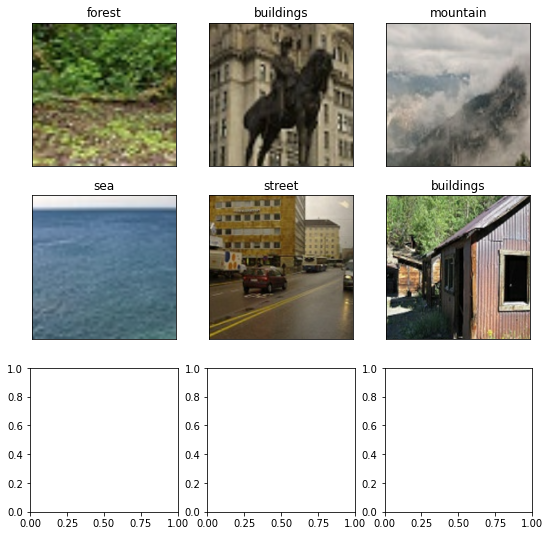

In [ ]:
images, labels = batch['image'][0][:6], batch['label'][0][:6]
titles = map(make_label_getter('intel'), labels.argmax(axis=1))
show_img_grid(images, titles)

## Load the pre-train model

In [ ]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 1024
name: ViT-L_16
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 4096
  num_heads: 16
  num_layers: 24

In [ ]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
# Here I am defining model for intel image classification

model = models.VisionTransformer(num_classes=num_classes, **model_config)

variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [ ]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


In [ ]:
# If have been running and it going down or crash in someway then load it back
# model_params_path = f'/content/Drive/MyDrive/vision_transformer/{model_name}'
# params = checkpoint.load(model_params_path)

## Evaluate on random initialization

In [ ]:
import flax
import jax
import tqdm
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (6,)
params_repl.cls: _ShardedDeviceArray (1, 6)


In [ ]:
for (keys, values) in params_repl.items():
    print(keys)
    if(keys != 'cls'):
        for(key, value) in params_repl[keys].items():
            print(f'\t {key}')

Transformer
	 encoder_norm
	 encoderblock_0
	 encoderblock_1
	 encoderblock_10
	 encoderblock_11
	 encoderblock_12
	 encoderblock_13
	 encoderblock_14
	 encoderblock_15
	 encoderblock_16
	 encoderblock_17
	 encoderblock_18
	 encoderblock_19
	 encoderblock_2
	 encoderblock_20
	 encoderblock_21
	 encoderblock_22
	 encoderblock_23
	 encoderblock_3
	 encoderblock_4
	 encoderblock_5
	 encoderblock_6
	 encoderblock_7
	 encoderblock_8
	 encoderblock_9
	 posembed_input
cls
embedding
	 bias
	 kernel
head
	 bias
	 kernel


In [ ]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [ ]:
def get_accuracy(params_repl):
    """Returns accuracy evaluated on the test set."""
    good = total = 0

    # Number of times it going to run until loading all the first batch in
    steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size

    for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
        predicted = vit_apply_repl(params_repl, batch['image'])

        pred_label = predicted.argmax(axis=-1)
        true_label = batch['label'].argmax(axis=-1)


        is_same = pred_label == true_label
        good += is_same.sum()
        total += len(is_same.flatten())
    return good / total, good, total

In [ ]:
dataset = 'intel'
ds_test = test_ds
ds_train = train_ds
batch_size = 64

In [ ]:
# Random performance without fine-tuning.
acc, good, total = get_accuracy(params_repl)

 11%|█         | 5/46 [01:21<11:12, 16.39s/it]


## Fine-tune

In [ ]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 64
base_lr = 0.03

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [ ]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [54:10<00:00, 32.51s/it]


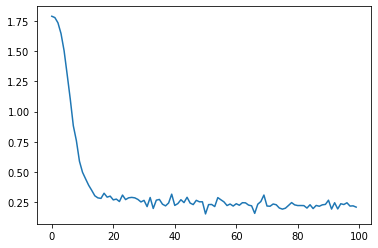

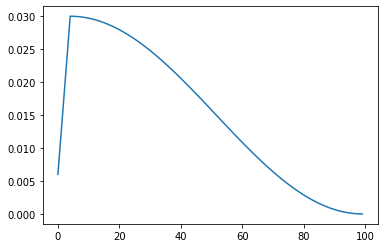

In [ ]:
# ViT-L/16 loss graph
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [ ]:
# This is performance of ViT-L_16 on Intel Image Dataset
get_accuracy(opt_repl.target)

 11%|█         | 5/46 [00:44<06:06,  8.94s/it]


(DeviceArray(0.9507813, dtype=float32), DeviceArray(2434, dtype=int32), 2560)